In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications import ResNet50

c:\Users\Viktor\AIDEL2\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

limit = 10000
x_train = x_train[:limit]
y_train = y_train[:limit]
x_test = x_test[:limit]
y_test = y_test[:limit]

x_train = x_train / 255.0
x_test = x_test / 255.0

print(np.shape(x_train))

c:\Users\Viktor\AIDEL2\venv\Lib\site-packages\keras\src\datasets\cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


(10000, 32, 32, 3)


In [3]:
print(np.shape(y_train))
print(y_train[0:5])

(10000, 1)
[[19]
 [29]
 [ 0]
 [11]
 [ 1]]


In [4]:
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
print(np.shape(y_train))
print(y_train)

(10000, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


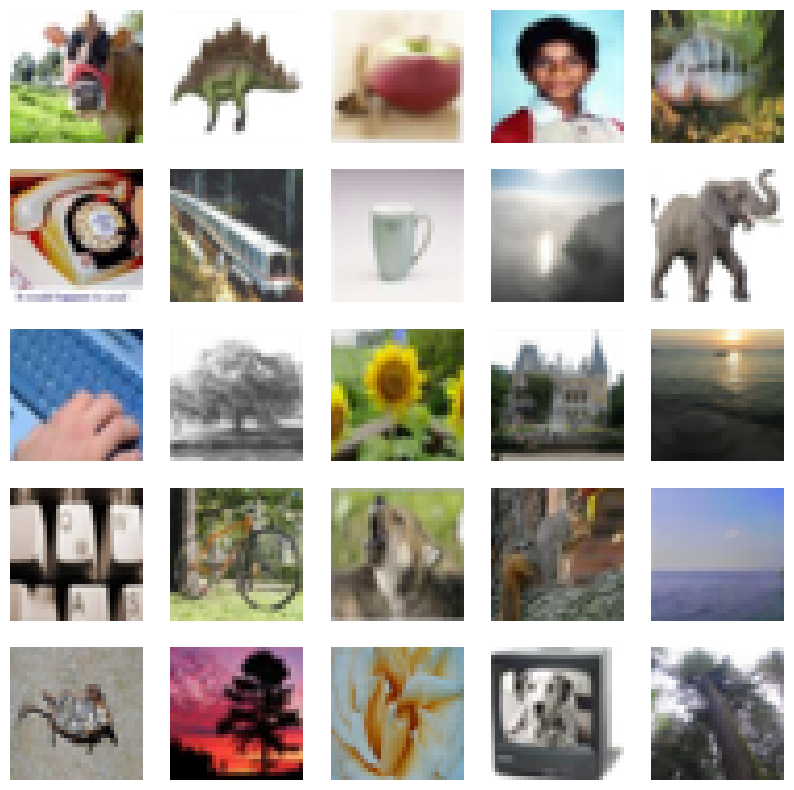

In [5]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i])
    plt.axis('off')

# B)

In [6]:
def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units', min_value=128, max_value=256, step=64),
        activation='relu'
    ))

    model.add(Dense(100, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='cifar100_dir',
    project_name='cifar100_tuning',
    overwrite=True
)

tuner.search(x_train, y_train, epochs=10, validation_split=0.2)


Trial 30 Complete [00h 01m 18s]
val_accuracy: 0.2574999928474426

Best val_accuracy So Far: 0.26600000262260437
Total elapsed time: 00h 15m 31s


In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

final_model = tuner.hypermodel.build(best_hps)

print("Startar om träningen med bästa inställningarna...")

history = final_model.fit(
    x_train, 
    y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

test_loss, test_acc = final_model.evaluate(x_test, y_test)
print(f"Slutgiltig Accuracy: {test_acc*100:.2f}%")


Startar om träningen med bästa inställningarna...
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0221 - loss: 4.4575 - val_accuracy: 0.0335 - val_loss: 4.3081
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0501 - loss: 4.1424 - val_accuracy: 0.0620 - val_loss: 3.9958
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0816 - loss: 3.9098 - val_accuracy: 0.1100 - val_loss: 3.7724
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.1221 - loss: 3.6933 - val_accuracy: 0.1335 - val_loss: 3.6314
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1583 - loss: 3.4628 - val_accuracy: 0.1530 - val_loss: 3.5637
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1959 - loss: 3.2543 - val_accuracy: 0.1740 - val_loss: 3.4476
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2371 - loss: 3.0459 - val_accuracy: 0.1980 - val_loss: 3.3148
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms

# C)

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, UpSampling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

print("Laddar data...")
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

limit = 1000
x_train = x_train[:limit]
y_train = y_train[:limit]
x_test = x_test[:limit]
y_test = y_test[:limit]

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

def build_transfer_model():
    inputs = Input(shape=(32, 32, 3))
    
    x = UpSampling2D(size=(2, 2))(inputs)
    
    base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=x)
    
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(100, activation='softmax')(x)
    
    return Model(inputs, outputs), base_model

model, base_model = build_transfer_model()

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print("Fas 1: Tränar bara toppen...")
history1 = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

print("\nFas 2: Fine-tuning (låser upp basmodellen)...")

base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history2 = model.fit(x_train, y_train, 
                     epochs=10, 
                     batch_size=64, 
                     validation_split=0.2,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
                     verbose=1)

print("\nUtvärderar...")
loss, acc = model.evaluate(x_test, y_test)
print(f"Slutgiltig Accuracy: {acc*100:.2f}%")

Laddar data...
Fas 1: Tränar bara toppen...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 699ms/step - accuracy: 0.0200 - loss: 5.7286 - val_accuracy: 0.0350 - val_loss: 5.4708
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.1275 - loss: 4.2381 - val_accuracy: 0.0750 - val_loss: 4.6915
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 280ms/step - accuracy: 0.2400 - loss: 3.2148 - val_accuracy: 0.1100 - val_loss: 4.2635
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.3638 - loss: 2.5559 - val_accuracy: 0.1300 - val_loss: 3.9010
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - accuracy: 0.4875 - loss: 2.1130 - val_accuracy: 0.1800 - val_loss: 3.6767
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.5512 - loss: 1.8092 - val_accuracy: 0.2000 - val_loss: 3.5286
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.5813 - loss: 1.5797 - val_accuracy: 0.2150 - val_loss: 3.3829
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accur

# 9 a)

Laddar modell...
Analyserar tennisboll.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


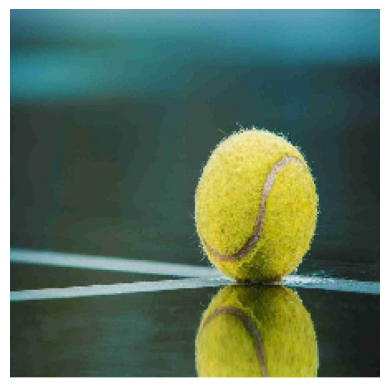


Modellens gissningar:
1. tennis_ball: 98.93%
2. racket: 0.61%
3. lemon: 0.05%
Modellen är sparad som cifar100_model.keras


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

print("Laddar modell...")
model = VGG16(weights='imagenet', include_top=True)

image_path = 'tennisboll.jpg' 

try:
    img = image.load_img(image_path, target_size=(224, 224))
    
    img_array = image.img_to_array(img)
    
    img_batch = np.expand_dims(img_array, axis=0)
    
    img_preprocessed = preprocess_input(img_batch)

    print(f"Analyserar {image_path}...")
    predictions = model.predict(img_preprocessed)

    results = decode_predictions(predictions, top=3)[0]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("\nModellens gissningar:")
    for i, (imagenet_id, label, score) in enumerate(results):
        print(f"{i+1}. {label}: {score*100:.2f}%")

    model.save("cifar100_model.keras")
    print("Modellen är sparad som cifar100_model.keras")

except FileNotFoundError:
    print(f"\nFEL: Kunde inte hitta filen '{image_path}'.")
    print("Se till att du har laddat upp bilden och att namnet stämmer exakt.")

# 9 B)

[Klicka här för att öppna Upgift 9B från Kapitel 8](./Upg9BKap8.py)